## Imports

In [1]:
from classy import Class
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import scipy.optimize as opt
import h5py

In [242]:
h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'

In [49]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")

## Parameters and Constants

In [5]:
spline_pars = {'k': 3, 's': 0.0}

z_pk = 0.0; #redshift at which Pk is determined
pk_max = 1.e2; #maximum k for Pk
kk = np.logspace(-4,np.log10(pk_max),500)
f_idm_dr = 1.0
omega0_cdm = 0.12038;


commonset = {
    'omega_b': 0.022032,
    'omega_cdm': omega0_cdm,
    'h': 0.67556,
    'A_s': 2.215e-9,
    'n_s': 0.9619,
    'tau_reio': 0.0925,
    'output': 'tCl,pCl,lCl,mPk',
    'lensing': 'yes',
    'P_k_max_1/Mpc': pk_max,
    'z_pk': 0.0,
    'k_output_values':'10',
}

idrset = {
    # Dark matter/radiation parameters
    'f_idm_dr': f_idm_dr, #Amount of dm that is interacting
    'xi_idr': 0.3, 
    'stat_f_idr': 0.875, #fermionic
    'nindex_idm_dr': 4.0, 
    'm_idm': 1.0e3,
    # Scattering rate parameters
    'a_idm_dr': 1.0e0,
    'rec_case': 4 #1 = power, 2 = Theta, 3 = delta function, 4 = no recoupling
}

## Functions

In [4]:
def getPk(classObj):
    kk = np.logspace(-4,np.log10(pk_max),500) # k in h/Mpc
    Pk = [] # P(k) in (Mpc/h)**3
    h = classObj.h() # get reduced Hubble for conversions to 1/Mpc
    for k in kk:
        Pk.append(classObj.pk(k*h,z_pk)*h**3) # function .pk(k,z)
    return Pk;

def getPkRatio(classObj1, classObj2):
    #Returns the ratio of the power spectrum of 1 to 2
    return[getPk(classObj1)[i]/getPk(classObj2)[i] for i in range(len(kk))]
    

def getdmu_idm_dr(classObj):
    return classObj.get_thermodynamics()['dmu_idm_dr']
    
def getzs(classObj):
    return classObj.get_thermodynamics()['z']

def getH(classObj):
    zs = np.flip(classObj.get_background()['z'])
    Hs = np.flip(classObj.get_background()['H [1/Mpc]'])
    return UnivariateSpline(zs, Hs, k=1.0, s=0.0)


def getDat(classObj):
    dmu_idm_dr = getdmu_idm_dr(classObj);
    zs = getzs(classObj);
    Hspline = getH(classObj);
    
    return dmu_idm_dr, zs, Hspline

def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, h =0.67556, xi_idr = 0.3 ):
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr * h**2 

    if T_rec >= (xi_idr * 2.73) * (1+z) and (xi_idr*2.73) * (1+z) > T_rec*0.99:
        return base_rate*(1+A_rec)
    else:
        return base_rate
def scientific_format(x):
    s = '%.1e' % x
    mantissa, exponent = s.split('e')
    return r'${} \times 10^{{{}}}$'.format(mantissa, int(exponent))

## ΛCDM

In [5]:
LambdaCDM = Class()
LambdaCDM.set(commonset)
LambdaCDM.compute()
LambdaCDMPk = getPk(LambdaCDM);

## IDR

In [6]:
idrNoRec = Class()
idrNoRec.set(commonset)
idrNoRec.set(idrset)

idrNoRec.compute()

# idrNoRecdmu_idm_dr, idrNoReczs, idrNoRecHspline = getDat(idrNoRec)

In [8]:
BM_KS = ['10']

In [111]:
model = idrNoRec
with h5py.File(h5pydir+'class_model_data_no_rec.hdf5', 'w') as f:    
    # Scalar group
    data = model.get_perturbations()['scalar']
    sub_group = f.create_group('scalar')
    for i, k in enumerate(BM_KS):
        sub_sub_group = sub_group.create_group(f'k={k}')
        d = data[i]
        for key, val in d.items():
            sub_sub_group.create_dataset(key, data=val)
    
    # Background group
    data = model.get_background()
    sub_group = f.create_group('background')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)
    
    # Thermo group
    data = model.get_thermodynamics()
    sub_group = f.create_group('thermodynamics')
    for key, val in data.items():
        sub_group.create_dataset(key, data=val)

    # Power Spectrum group
    data = getPk(model)
    sub_group = f.create_group('power_spectrum')
    sub_group.create_dataset('kk', data=kk)
    sub_group.create_dataset('Pk', data=data) 

In [34]:
def save_class_obj(class_obj,A_rec):
    model = class_obj
    data_file=h5pydir+'class_model_data_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'w') as f:    
        # Scalar group
        data = model.get_perturbations()['scalar']
        sub_group = f.create_group('scalar')
        for i, k in enumerate(BM_KS):
            sub_sub_group = sub_group.create_group(f'k={k}')
            d = data[i]
            for key, val in d.items():
                sub_sub_group.create_dataset(key, data=val)
        
        # Background group
        data = model.get_background()
        sub_group = f.create_group('background')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)
        
        # Thermo group
        data = model.get_thermodynamics()
        sub_group = f.create_group('thermodynamics')
        for key, val in data.items():
            sub_group.create_dataset(key, data=val)

        # Power Spectrum group
        data = getPk(model)
        sub_group = f.create_group('power_spectrum')
        sub_group.create_dataset('kk', data=kk)
        sub_group.create_dataset('Pk', data=data) 
    

In [243]:
k = '10' #only one k mode for now
A_recs = [1e5, 10**(5.5), 1e6]

for A_rec in A_recs:
    data_file=h5pydir+'/class_model_data_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'r') as f:
        tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
        delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
        phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
        
        delta_chi = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
        delta_chi_dot = delta_chi.derivative()
        phi = UnivariateSpline(tau_data, phi_data, **spline_pars)
        phi_dot = phi.derivative()

        Pks = np.array(f['power_spectrum']['Pk'])
        kks = np.array(f['power_spectrum']['kk'])

        kappa_dot_data = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
        z_data = np.flip(np.array(f['thermodynamics']['z']))

## Delta Function Recoupling

In [35]:
# A_recs = [1e5, 10**(5.5), 1e6, 1e8, 1e10, 1e11]
A_recs = [1e5, 10**(5.5), 1e6]

In [36]:
for A_rec in A_recs:
    cos = Class()
    cos.set(commonset)
    cos.set(idrset)
    cos.set({
        'rec_case': 3,
        'A_rec':A_rec,
        'T_rec':6.0e5,
        })
    cos.compute() 

    save_class_obj(cos,A_rec)
    
    # clear content of cos (to reuse it for another model)
    cos.struct_cleanup()
    # reset parameters to default
    cos.empty()

## Read in h5py file

In [244]:
data_file=h5pydir+'class_model_data_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))

In [245]:
k = '10' #only one k mode for now
delta_chi_dot_arr = []
phi_dot_arr = []
Pk_arr = []
kappa_dot_taus_arr = []
kappa_dot_zs_arr = []
z_arr = []
tau_arr = []
thermo_tau_arr = []
for A_rec in A_recs:
    data_file=h5pydir+'class_model_data_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'r') as f:
        tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
        delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
        phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
        kappa_dot_data = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
        z_data = np.flip(np.array(f['thermodynamics']['z']))
        thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
        
        delta_chi = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
        delta_chi_dot = delta_chi.derivative()
        phi = UnivariateSpline(tau_data, phi_data, **spline_pars)
        phi_dot = phi.derivative()
        kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)
        kappa_dot_zs = UnivariateSpline(np.flip(z_data), np.flip(kappa_dot_data), **spline_pars)
        thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)

        Pks = np.array(f['power_spectrum']['Pk'])
        kks = np.array(f['power_spectrum']['kk'])

        delta_chi_dot_arr.append(delta_chi_dot)
        Pk_arr.append(Pks)
        kappa_dot_taus_arr.append(kappa_dot_taus)
        kappa_dot_zs_arr.append(kappa_dot_zs)
        z_arr.append(z_data)
        tau_arr.append(tau_data)
        phi_dot_arr.append(phi_dot)
        thermo_tau_arr.append(thermo_taus)

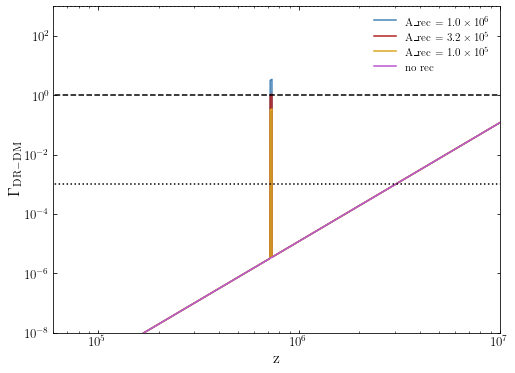

In [246]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(z_arr[i], kappa_dot_zs_arr[i](z_arr[i]), label='A_rec = ' + scientific_format(A_rec))

plt.plot(z_data_no_rec, kappa_dot_data_no_rec, label='no rec ')

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e4,1e7)
plt.ylim(1e-8,1e3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.legend()
plt.show()

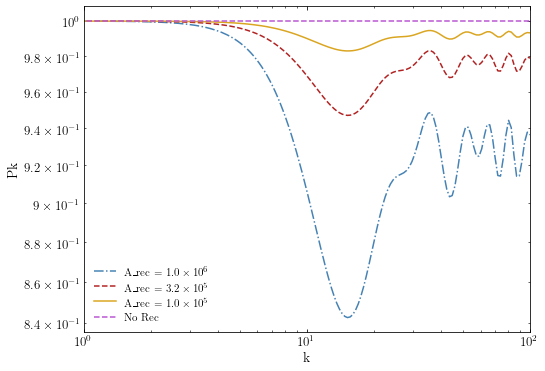

In [247]:
lines = ["-","--","-.",":"]
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(kk, Pk_arr[i]/Pks_no_rec,  ls = lines[i%len(lines)], label='A_rec = ' + scientific_format(A_rec))

plt.plot(kk,Pks_no_rec/Pks_no_rec, '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Pk')
plt.xlim(1,1e2)
plt.legend()
# plt.savefig('Figures/Pk_delta_ratio_more')
plt.show()

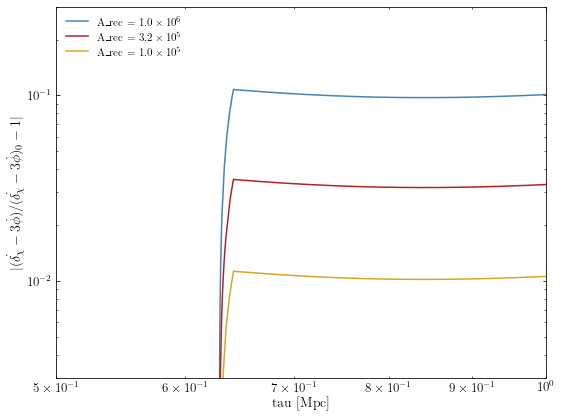

In [248]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    taus = tau_arr[i]
    plt.plot(taus, abs((delta_chi_dot_arr[i](taus) - 3*phi_dot_arr[i](taus))/(delta_chi_dot_no_rec(taus) - 3*phi_dot_no_rec(taus)) - 1), label='A_rec = ' + scientific_format(A_rec))
 
    # plt.plot(np.linspace(0.1,1,100), (np.exp(dTaus[i]*S_inv*dmu_peaks[i])-1)*np.ones(100), 'k--')

plt.xlim(5e-1,1e0)
plt.xlabel('tau [Mpc]')
plt.ylabel('$|(\dot{\delta_\chi} - 3 \dot\phi )/ (\dot{\delta_\chi} - 3 \dot\phi)_0 - 1|$')

plt.legend(loc='upper left')

plt.yscale('log')
plt.xscale('log')
plt.ylim(3e-3,3e-1)


plt.tight_layout()

# plt.savefig('Figures/delta_chi_compare2.pdf')

In [229]:
S_inv = 4/3*(idrNoRec.get_background()['(.)rho_idr']/idrNoRec.get_background()['(.)rho_idm_dr'])[2685]

In [231]:
myzs = np.logspace(5.5,6.3,10000) #Assume peak occurs in this range (which it does for T_rec = 6e5)
dmu_peaks = []
dTaus = []
for i, A_rec in enumerate(A_recs):
    mytaus = thermo_tau_arr[i](myzs)
    peak_idxs = np.where(kappa_dot_taus_arr[i](mytaus)>=1e-3) #indices in tau for which DM is recoupled, assuming the peak is greater than 1e-3
    peak_taus = mytaus[peak_idxs]
    dTau = np.max(peak_taus) - np.min(peak_taus) #conformal time spent in peak
    dmu_peak = np.max(kappa_dot_taus_arr[i](peak_taus)) #Max comoving rate during recoupling

    dmu_peaks.append(dmu_peak)
    dTaus.append(dTau)

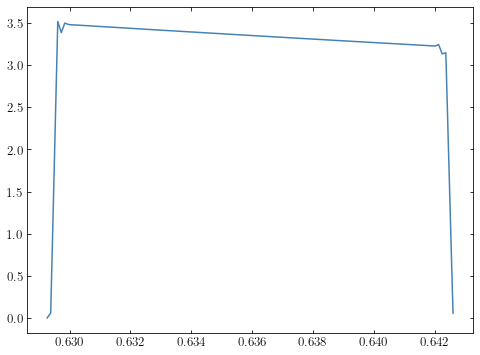

In [233]:
plt.plot(peak_taus, kappa_dot_taus_arr[2](peak_taus))
plt.show()

In [238]:
myzs = np.logspace(5.5,6.3,100000) #Assume peak occurs in this range (which it does for T_rec = 6e5)
dmu_peaks = []
dTaus = []
for i, A_rec in enumerate(A_recs):
    mytaus = thermo_tau_arr[i](myzs)
    peak_idxs = np.where(kappa_dot_taus_arr[i](mytaus)>=5e-4) #indices in tau for which DM is recoupled, assuming the peak is greater than 1e-3
    peak_taus = mytaus[peak_idxs]
    dTau = np.max(peak_taus) - np.min(peak_taus) #conformal time spent in peak
    dmu_peak = np.max(kappa_dot_taus_arr[i](peak_taus)) #Max comoving rate during recoupling

    dmu_peaks.append(dmu_peak)
    dTaus.append(dTau)

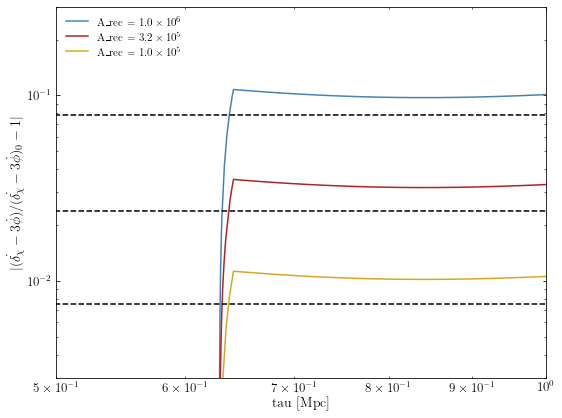

In [240]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    taus = tau_arr[i]
    plt.plot(taus, abs((delta_chi_dot_arr[i](taus) - 3*phi_dot_arr[i](taus))/(delta_chi_dot_no_rec(taus) - 3*phi_dot_no_rec(taus)) - 1), label='A_rec = ' + scientific_format(A_rec))
 
    plt.plot(np.linspace(0.1,1,100), (np.exp(dTaus[i]*S_inv*dmu_peaks[i])-1)*np.ones(100), 'k--')

plt.xlim(5e-1,1e0)
plt.xlabel('tau [Mpc]')
plt.ylabel('$|(\dot{\delta_\chi} - 3 \dot\phi )/ (\dot{\delta_\chi} - 3 \dot\phi)_0 - 1|$')

plt.legend(loc='upper left')

plt.yscale('log')
plt.xscale('log')
plt.ylim(3e-3,3e-1)


plt.tight_layout()

# plt.savefig('Figures/delta_chi_compare2.pdf')